# AIML CA1

## Import General Dependencies

In [17]:
# Mathematical Dependencies
import numpy as np

# Data Manipulation Dependencies
import pandas as pd

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline

# Miscellaneous Dependencies
from typing import Callable, Dict # static typing
import re   # regex

## Utility Functions

In [18]:
def extract_attributes(metadata: str, target: str) -> Dict[str, Dict[str, str]]:
    '''
    Extract attribute data from ./data/agaricus-lepiota.names file
    '''

    # extract attributes section
    attribute_section = re.findall(target, metadata)[0][0]

    # remove all whitespace
    trimmed_whitespace = re.sub(r'[\s]+', '', attribute_section)

    # split attributes by list numbers
    # remove list numbering
    split_attrs = re.split(r'[\d]+\.', trimmed_whitespace)[1:]      
    
    # attr_dict - final attribute dictionary
    attr_dict = {
        'class': {
            'e': 'edible',
            'p': 'poisonous'
        }
    }
    for attr in split_attrs:
        # attr - raw attribute form
        # e.g. "cap-shape:bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s"
        
        val_dict = {}
        # val_dict - value dictionary for each attribute
        # e.g.
        #   'cap-shape': {
        #       'b': 'bell',
        #       'c': 'conical' ...
        #   }

        name, vals = attr.split(':')
        # name - attribute name
        # e.g. "cap-shape"

        # vals - string of raw attribute pairs
        # e.g. "bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s"
        for val in vals.split(','):
            # vals.split(',') - list of raw attribute pairs
            # e.g. ["bell=b", "conical=c", "convex=x", "flat=f", "knobbed=k", "sunken=s"]

            # val - raw attribute pair
            # e.g. "bell=b"
            definition, code = val.split('=')
            # definition - full form of an attribute value
            # e.g. "bell"

            # code - short form of an attribute value
            # e.g. "b"
            val_dict[code] = definition
        attr_dict[name] = val_dict
    return attr_dict

## Part I

### Import Exclusive Dependencies

In [19]:
# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Classification Metrics
from sklearn.metrics import confusion_matrix

### Import Data

In [20]:
# ./data/agaricus-lepiota.names file's content
metadata: str
with open('./data/agaricus-lepiota.names') as f:
    metadata = f.read()

# extracted attributes
attrs = extract_attributes(metadata, r'7\. Attribute Information:.*\n((.|\n)*)8\. Missing')

# column names to be used for dataframe
cols = attrs.keys()

In [21]:
# create the dataframe from ./data/agaricus-lepiota.data file,
#   using column names derived from ./data/agaricus-lepiota.names file
df = pd.read_csv(
    filepath_or_buffer='./data/agaricus-lepiota.data',
    sep=',',
    header=0,
    names=cols
)

# expand attribute codes to their full versions
for col in cols:
    df[col].replace(to_replace=attrs[col] ,inplace=True)

#### Peek Into Data

In [22]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
1,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
2,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
3,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
4,edible,convex,scaly,yellow,bruises,almond,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,black,numerous,grasses


#### Summarize Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8123 non-null   object
 1   cap-shape                 8123 non-null   object
 2   cap-surface               8123 non-null   object
 3   cap-color                 8123 non-null   object
 4   bruises?                  8123 non-null   object
 5   odor                      8123 non-null   object
 6   gill-attachment           8123 non-null   object
 7   gill-spacing              8123 non-null   object
 8   gill-size                 8123 non-null   object
 9   gill-color                8123 non-null   object
 10  stalk-shape               8123 non-null   object
 11  stalk-root                8123 non-null   object
 12  stalk-surface-above-ring  8123 non-null   object
 13  stalk-surface-below-ring  8123 non-null   object
 14  stalk-color-above-ring  

In [24]:
df.describe().transpose()

,count,unique,top,freq
class,8123,2,edible,4208
cap-shape,8123,6,convex,3655
cap-surface,8123,4,scaly,3244
cap-color,8123,10,brown,2283
bruises?,8123,2,no,4748
odor,8123,9,none,3528
gill-attachment,8123,2,free,7913
gill-spacing,8123,2,close,6811
gill-size,8123,2,broad,5612
gill-color,8123,12,buff,1728


### Pre-Processing

#### EDA

In [25]:
# Check for missing values
df.isna().any(axis=0)

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises?                    False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

In [26]:
yoyo = pd.get_dummies(df, drop_first=True)
yo = yoyo.corr()['class_poisonous']
yoy = yo.quantile(q=0.9)
yoneg = yo.quantile(q=0.1)
yo[(yo > yoy) | (yo < yoneg)]

class_poisonous                    1.000000
bruises?_no                        0.501758
odor_foul                          0.623974
odor_none                         -0.785534
gill-spacing_crowded              -0.348358
gill-size_narrow                   0.539944
gill-color_brown                  -0.288916
gill-color_buff                    0.538919
gill-color_white                  -0.231281
stalk-surface-above-ring_silky     0.587794
stalk-surface-above-ring_smooth   -0.491460
stalk-surface-below-ring_silky     0.573656
stalk-surface-below-ring_smooth   -0.425592
stalk-color-above-ring_gray       -0.266472
stalk-color-below-ring_gray       -0.266472
ring-type_large                    0.451710
ring-type_pendant                 -0.540670
spore-print-color_brown           -0.416609
spore-print-color_chocolate        0.490333
population_several                 0.443906
Name: class_poisonous, dtype: float64

In [27]:
# Presentation
def present():
    df_tmp = df.copy()
    tmp_1hot = pd.get_dummies(df_tmp, drop_first=True)
    tmp_X = tmp_1hot['class']
    tmp_y = tmp_1hot.drop('class', axis=1)

In [28]:
dfdf = pd.get_dummies(df, drop_first=True)

<AxesSubplot:xlabel='class', ylabel='count'>

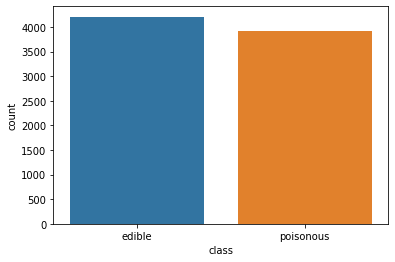

In [29]:
sns.countplot(data=df, x='class')

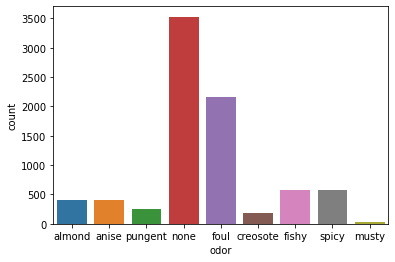

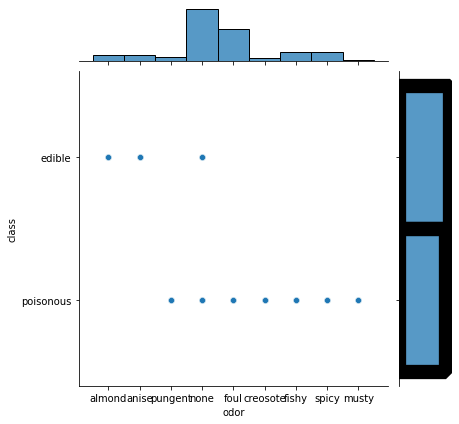

In [30]:
sns.countplot(data=df, x='odor')
sns.jointplot(data=df, x='odor', y='class')

In [31]:
knn = KNeighborsClassifier(n_neighbors=4)
y = dfdf['class_poisonous']
X = dfdf.drop(labels='class_poisonous', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
# confusion_matrix(y_test, knn.predict(X_test))
# print(X_test.shape)

0.9987690413909832

## Part II

### Import Exclusive Dependencies

In [32]:
# Machine Learning Models (Regression)
from sklearn.linear_model import LinearRegression, BayesianRidge

### Import Data

In [33]:
# 
df2 = pd.read_csv('./data/kc_house_data.csv')

#### Peek Into Data

In [34]:
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#### Summarize Data

In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [45]:
df2.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1000102.00,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,75000.00,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370000e+00,9.300000e-01,0.00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.110000e+00,7.700000e-01,0.00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184400e+02,290.00,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,520.00,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.490000e+00,5.400000e-01,1.00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,1.000000e-02,9.000000e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.300000e-01,7.700000e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.410000e+00,6.500000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


### Pre-Processing

#### EDA

In [37]:
# Check for missing values
df2.isna().any(axis=0)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

<AxesSubplot:xlabel='price'>

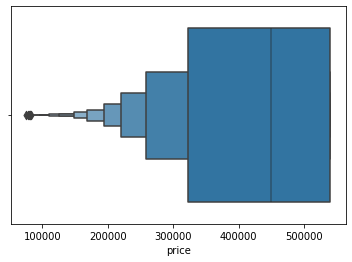

In [38]:
df_tmp = df2.copy()
df_tmp[df_tmp['price'] > df2['price'].mean()] = df2['price'].mean()
sns.boxenplot(data=df_tmp, x='price')

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

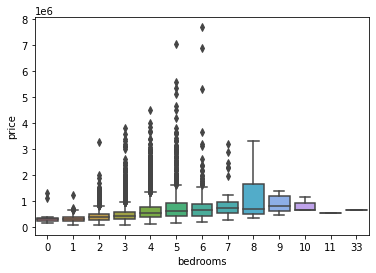

In [39]:
sns.boxplot(data=df2, x='bedrooms', y='price')

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

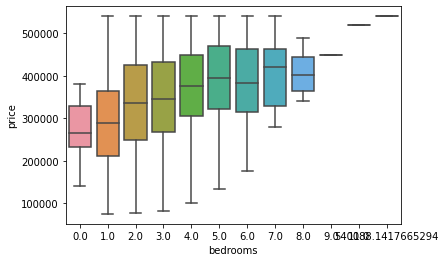

In [40]:
sns.boxplot(data=df_tmp, x='bedrooms', y='price')

In [41]:
# Check for outliers
outliers2 = df2[df2['']]

KeyError: ''

#### Feature Engineering

#### Feature Selection

In [59]:
df2['date']

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [71]:
df2_corr = df2.corr()
df2_corr.drop(labels=df2_corr.columns[df2_corr.columns != 'price'].values, axis=1).drop(labels='price', axis=0)['price'].sort_values(ascending=False)

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

#### Data Partitioning

In [117]:
X2 = df_tmp[['sqft_living', 'grade']]
y2 = df_tmp['price']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

#! delete !#
model2 = LinearRegression()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714955890475
0.6120830223958837


#### Model Training

In [119]:
model2 = LinearRegression()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714955890475
0.6120830223958837


In [118]:
model2 = BayesianRidge()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714650952643
0.6120755718675807


In [121]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, Lars

for m in [Ridge, Lasso, ElasticNet, Lars]:
    p = m()
    try:
        p.fit(X2_train, y2_train)
        print(p.score(X2_test, y2_test))
    except Exception:
        pass

0.6120830223909768
c:\Users\ethanol\Documents\SP\Current\AI and Machine Learning (AIML)\CA1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56037237319947.92, tolerance: 24904296381.3108
  model = cd_fast.enet_coordinate_descent(
0.541520468522968
0.541520468544832
0.6120830223986291
c:\Users\ethanol\Documents\SP\Current\AI and Machine Learning (AIML)\CA1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56037241180363.42, tolerance: 24904296381.3108
  model = cd_fast.enet_coordinate_descent(
